https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial



In [3]:
import networkx as nx
import itertools
import copy
import pandas as pd
import matplotlib.pyplot as plt

Find shortest path that covers all trails at least once. We will construct a Eulerian tour graph where a cycle can be made from a starting node back to itself passing through each edge exactly once. 

A matching is a subset of edges in which no node occurs more than once. We're interested in the minimum weight matching which is the matching with the lowest summed edge weight.

# Data 


In [4]:
edgelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv')

In [5]:
edgelist.head()

node1 node2 trail  distance color  estimate
0  rs_end_north  v_rs    rs      0.30   red         0
1          v_rs  b_rs    rs      0.21   red         0
2          b_rs  g_rs    rs      0.11   red         0
3          g_rs  w_rs    rs      0.18   red         0
4          w_rs  o_rs    rs      0.21   red         0

In [6]:
# include nodelist with attributes so can 
# overlay nodes on a map
nodelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv')

In [7]:
nodelist.head()

id     X     Y
0        b_bv  1486   732
1        b_bw   716  1357
2  b_end_east  3164  1111
3  b_end_west   141  1938
4         b_g  1725   771

# Create Graph

In [10]:
G = nx.Graph()

In [117]:
G = nx.from_pandas_edgelist(edgelist, source='node1', target='node2', edge_attr=True)

In [118]:
list(G.edges.data())[:2]

[('rs_end_north',
  'v_rs',
  {'node1': 'rs_end_north',
   'node2': 'v_rs',
   'trail': 'rs',
   'distance': 0.3,
   'color': 'red',
   'estimate': 0}),
 ('v_rs',
  'b_rs',
  {'node1': 'v_rs',
   'node2': 'b_rs',
   'trail': 'rs',
   'distance': 0.21,
   'color': 'red',
   'estimate': 0})]

In [119]:
for i, nlrow in nodelist.iterrows():
    G.nodes[nlrow['id']].update(nlrow[1:].to_dict())

In [120]:
list(G.nodes.data())[:3]

[('rs_end_north', {'X': 1772, 'Y': 172}),
 ('v_rs', {'X': 1793, 'Y': 484}),
 ('b_rs', {'X': 1747, 'Y': 700})]

In [121]:
print('edges: {}, nodes: {}'.format(G.number_of_edges(),G.number_of_nodes()))


edges: 123, nodes: 77


In [122]:
#format node positions for plotting tool
node_positions = {k: (v['X'],-v['Y']) for k,v in dict(G.nodes.data()).items()}
list(node_positions.items())[0:3]

[('rs_end_north', (1772, -172)),
 ('v_rs', (1793, -484)),
 ('b_rs', (1747, -700))]

In [131]:
#format edge_colors for plotting tool
edge_colors=[e[2] for e in G.edges.data('color')]
edge_colors[0:3]

['red', 'red', 'violet']

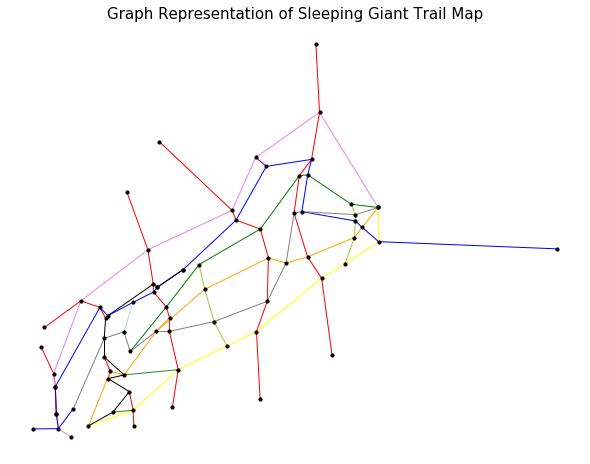

In [134]:
plt.figure(figsize=(8, 6))
nx.draw(G, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black')
plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

# Solve Postman Problem

nodes of odd degree require backtracking, so start by finding the nodes of odd degree and add a duplicate edge which minimizes the distances between them. Then find Eulerian tour through the new graph.


In [141]:
# list of nodes with odd degree
nodes_odd_degree = [v for v, d in G.degree() if d % 2 == 1]
print(nodes_odd_degree[:3])
print(len(nodes_odd_degree))

['rs_end_north', 'rs_end_south', 'rc_end_north']
36


In [144]:
#Next find minimum distance pairs - this is np-hard

# All pairs of odd degree nodes
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))


print(len(odd_node_pairs[0:3]))
print(len(odd_node_pairs))


3
630


In [145]:
# shortest path between each node pair - Dijkstra's

def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [147]:

odd_node_pairs_shortest_paths = get_shortest_paths_distances(G, odd_node_pairs, 'distance')

dict(list(odd_node_pairs_shortest_paths.items())[0:4])

{('rs_end_north', 'rs_end_south'): 1.52,
 ('rs_end_north', 'rc_end_north'): 1.79,
 ('rs_end_north', 'rc_end_south'): 1.79,
 ('rs_end_north', 'rt_end_north'): 1.8900000000000001}

In [288]:
# Complete graph of the odd node pairs

def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters:
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], distance= v, weight=wt_i)
    return g

In [289]:
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 36
Number of edges: 630


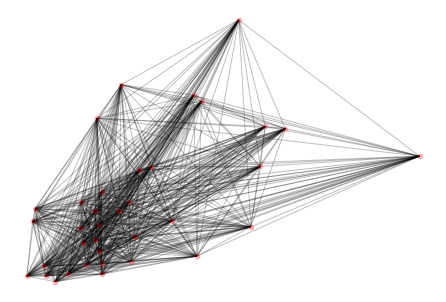

In [155]:
# The edges don't represent individual trails,
# instead they're shortest path between the trails
# for odd degree nodes

nx.draw(g_odd_complete,pos=node_positions, node_size=20, alpha=0.25)

In [291]:
# Odd degree node pairs whose combined weights is as small as possible
# This is an optimization problem called Maximum Matching problem

odd_matching_dict = nx.algorithms.max_weight_matching(g_odd_complete, True)

print(len(odd_matching_dict))
print(list(odd_matching_dict)[:3])

18
[('y_rh', 'rh_end_south'), ('rs_end_north', 'v_end_east'), ('b_end_east', 'g_gy2')]


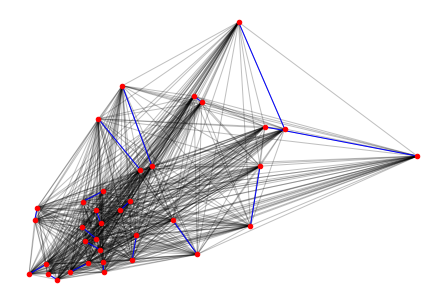

In [292]:
odd_matching=list(odd_matching_dict)

nx.draw(g_odd_complete,pos=node_positions, node_size=20, alpha=0.25)
#overlay min-weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue')

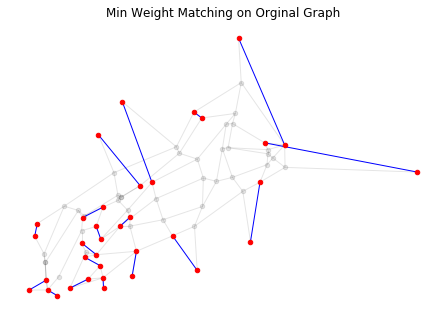

In [293]:
# Now that have minimum weighted pairs for the odd nodes
# use those to find the shortest Eulerian circuit

# Plot the original trail map graph
nx.draw(G, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

In [294]:
# add min weight edges to original graph

def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """

    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0],
                           pair[1],
                           distance = nx.dijkstra_path_length(graph, pair[0], pair[1]),
                           trail= 'augmented'
                          )
    return graph_aug


In [295]:
g_aug = add_augmenting_path_to_graph(G, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(G.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))


Number of edges in original graph: 123
Number of edges in augmented graph: 141


In [296]:
#all even degrees
pd.value_counts([d for n, d in g_aug.degree()])


4    54
2    18
6     5
dtype: int64

In [297]:
#Eulerian circuit
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source='b_end_east'))

print(naive_euler_circuit[0:3])
print(len(naive_euler_circuit))

[('b_end_east', 'g_gy2'), ('g_gy2', 'park_east'), ('park_east', 'b_y')]
141


This shows the path through nodes. We want to also know the edge that we took to get between the nodes. We also want to return the actual path taken through the augmented edges, since those pairs could be a path through multiple nodes. 

In [298]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))

    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    

        if edge_data[0]['trail'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att))
        else:
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))

            # If `edge` does not exist in original graph, find the shortest path between its nodes and
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))

    return euler_circuit

In [299]:
euler_circuit = create_eulerian_circuit(g_aug, G, 'b_end_east')

Filling in edges for augmented edge: ('b_end_east', 'g_gy2')
Augmenting path: b_end_east => b_y => b_o => b_gy2 => w_gy2 => g_gy2
Augmenting path pairs: [('b_end_east', 'b_y'), ('b_y', 'b_o'), ('b_o', 'b_gy2'), ('b_gy2', 'w_gy2'), ('w_gy2', 'g_gy2')]

Filling in edges for augmented edge: ('y_gy2', 'rs_end_south')
Augmenting path: y_gy2 => y_rs => rs_end_south
Augmenting path pairs: [('y_gy2', 'y_rs'), ('y_rs', 'rs_end_south')]

Filling in edges for augmented edge: ('y_gy1', 'rc_end_south')
Augmenting path: y_gy1 => y_rc => rc_end_south
Augmenting path pairs: [('y_gy1', 'y_rc'), ('y_rc', 'rc_end_south')]

Filling in edges for augmented edge: ('b_end_west', 'rd_end_south')
Augmenting path: b_end_west => b_v => rd_end_south
Augmenting path pairs: [('b_end_west', 'b_v'), ('b_v', 'rd_end_south')]

Filling in edges for augmented edge: ('b_bw', 'rh_end_tt_1')
Augmenting path: b_bw => b_tt_1 => rh_end_tt_1
Augmenting path pairs: [('b_bw', 'b_tt_1'), ('b_tt_1', 'rh_end_tt_1')]

Filling in edges

In [300]:
print(len(euler_circuit))

158


In [301]:
euler_circuit[:3]

[('b_end_east',
  'b_y',
  {'node1': 'b_y',
   'node2': 'b_end_east',
   'trail': 'b',
   'distance': 1.32,
   'color': 'blue',
   'estimate': 0}),
 ('b_y',
  'b_o',
  {'node1': 'b_o',
   'node2': 'b_y',
   'trail': 'b',
   'distance': 0.08,
   'color': 'blue',
   'estimate': 0}),
 ('b_o',
  'b_gy2',
  {'node1': 'b_gy2',
   'node2': 'b_o',
   'trail': 'b',
   'distance': 0.05,
   'color': 'blue',
   'estimate': 1})]

# Results

In [302]:
total_mileage_of_circuit = sum([edge[2]['distance'] for edge in euler_circuit])
total_mileage_on_orig_trail_map = sum(nx.get_edge_attributes(G, 'distance').values())
_vcn = pd.value_counts(pd.value_counts([(e[0]) for e in euler_circuit]), sort=False)
node_visits = pd.DataFrame({'n_visits': _vcn.index, 'n_nodes': _vcn.values})
_vce = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(euler_circuit).edges()]))
edge_visits = pd.DataFrame({'n_visits': _vce.index, 'n_edges': _vce.values})

# Printing stats
print('Mileage of circuit: {0:.2f}'.format(total_mileage_of_circuit))
print('Mileage on original trail map: {0:.2f}'.format(total_mileage_on_orig_trail_map))
print('Mileage retracing edges: {0:.2f}'.format(total_mileage_of_circuit-total_mileage_on_orig_trail_map))
print('Percent of mileage retraced: {0:.2f}%\n'.format((1-total_mileage_of_circuit/total_mileage_on_orig_trail_map)*-100))

print('Number of edges in circuit: {}'.format(len(euler_circuit)))
print('Number of edges in original graph: {}'.format(len(G.edges())))
print('Number of nodes in original graph: {}\n'.format(len(G.nodes())))

print('Number of edges traversed more than once: {}\n'.format(len(euler_circuit)-len(G.edges())))  

print('Number of times visiting each node:')
print(node_visits.to_string(index=False))

print('\nNumber of times visiting each edge:')
print(edge_visits.to_string(index=False))

Mileage of circuit: 33.59
Mileage on original trail map: 25.76
Mileage retracing edges: 7.83
Percent of mileage retraced: 30.40%

Number of edges in circuit: 158
Number of edges in original graph: 123
Number of nodes in original graph: 77

Number of edges traversed more than once: 35

Number of times visiting each node:
n_visits  n_nodes
       1       18
       2       38
       3       20
       4        1

Number of times visiting each edge:
n_visits  n_edges
       1       88
       2       35


# Visualizating Solution Path

In [303]:
# convert Euler circuit to edge list

def create_cpp_edgelist(euler_circuit):
    """
    Create the edgelist without parallel edge for the visualization
    Combine duplicate edges and keep track of their sequence and # of walks
    Parameters:
        euler_circuit: list[tuple] from create_eulerian_circuit
    """
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])

        if edge in cpp_edgelist:
            cpp_edgelist[edge][2]['sequence'] += ', ' + str(i)
            cpp_edgelist[edge][2]['visits'] += 1

        else:
            cpp_edgelist[edge] = e
            cpp_edgelist[edge][2]['sequence'] = str(i)
            cpp_edgelist[edge][2]['visits'] = 1

    return list(cpp_edgelist.values())

In [305]:
cpp_edgelist = create_cpp_edgelist(euler_circuit)
print(len(cpp_edgelist))
print(cpp_edgelist[:3])

123
[('b_end_east', 'b_y', {'node1': 'b_y', 'node2': 'b_end_east', 'trail': 'b', 'distance': 1.32, 'color': 'blue', 'estimate': 0, 'sequence': '0, 157', 'visits': 2}), ('b_y', 'b_o', {'node1': 'b_o', 'node2': 'b_y', 'trail': 'b', 'distance': 0.08, 'color': 'blue', 'estimate': 0, 'sequence': '1, 156', 'visits': 2}), ('b_o', 'b_gy2', {'node1': 'b_gy2', 'node2': 'b_o', 'trail': 'b', 'distance': 0.05, 'color': 'blue', 'estimate': 1, 'sequence': '2, 155', 'visits': 2})]


In [306]:
G_cpp=nx.Graph(cpp_edgelist)

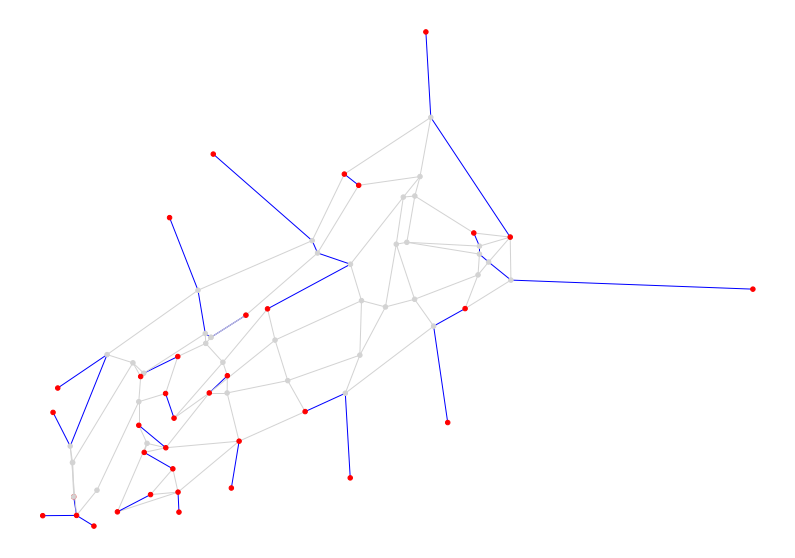

In [310]:
# grey if walked once, blue if walked more than once
plt.figure(figsize=(14, 10))

visit_colors = {1:'lightgray', 2:'blue'}
edge_colors = [visit_colors[e[2]['visits']] for e in G_cpp.edges(data=True)]
node_colors = ['red'  if node in nodes_odd_degree else 'lightgray' for node in G_cpp.nodes()]

nx.draw_networkx(G_cpp, pos=node_positions, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
plt.axis('off')
plt.show()

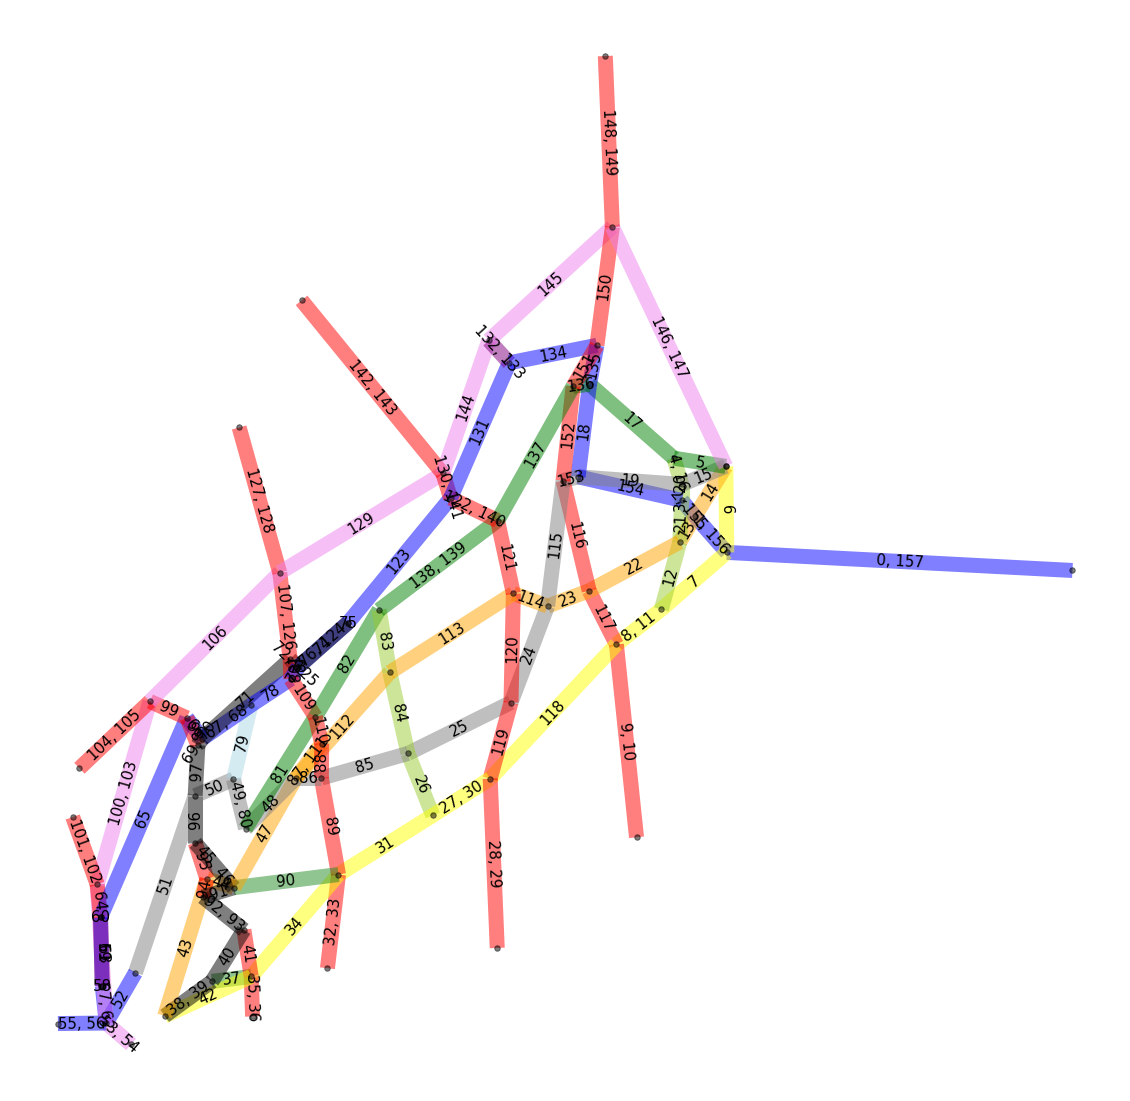

In [330]:
# mark the edges based on the order that they're traversed
plt.figure(figsize=(20, 20))

edge_colors = [e[2]['color'] for e in G_cpp.edges(data=True)]
nx.draw_networkx(G_cpp, pos=node_positions, node_size=30, node_color='black', edge_color=edge_colors, width=15,
                 with_labels=False, alpha=0.5)

bbox = {'ec':[1,1,1,0], 'fc':[1,1,1,0]}  # hack to label edges over line (rather than breaking up line)
edge_labels = nx.get_edge_attributes(G_cpp, 'sequence')
nx.draw_networkx_edge_labels(G_cpp, pos=node_positions, edge_labels=edge_labels, bbox=bbox, font_size=15)

plt.axis('off')
plt.show()

In [340]:
# animate path by saving an image for every step

import os
#os.mkdir('fig'); os.mkdir('fig/png');

visit_colors = {1:'black', 2:'red'}
edge_cnter = {}
g_i_edge_colors = []
for i, e in enumerate(euler_circuit, start=1):

    edge = frozenset([e[0], e[1]])
    if edge in edge_cnter:
        edge_cnter[edge] += 1
    else:
        edge_cnter[edge] = 1

    # Full graph (faded in background)
    nx.draw_networkx(G_cpp, pos=node_positions, node_size=6, node_color='gray', with_labels=False, alpha=0.07)

    # Edges walked as of iteration i
    euler_circuit_i = copy.deepcopy(euler_circuit[0:i])
    for i in range(len(euler_circuit_i)):
        edge_i = frozenset([euler_circuit_i[i][0], euler_circuit_i[i][1]])
        euler_circuit_i[i][2]['visits_i'] = edge_cnter[edge_i]
    g_i = nx.Graph(euler_circuit_i)
    g_i_edge_colors = [visit_colors[e[2]['visits_i']] for e in g_i.edges(data=True)]

    nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=g_i_edge_colors, alpha=0.8)

    plt.axis('off')
    plt.savefig('fig/png/img{}.png'.format(i), dpi=120, bbox_inches='tight')
    plt.close()

In [343]:
#stitch into gif
import glob
import numpy as np
import imageio


def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


In [347]:
make_circuit_video('fig/png/', 'fig/cpp_route_animation.gif', fps=4)

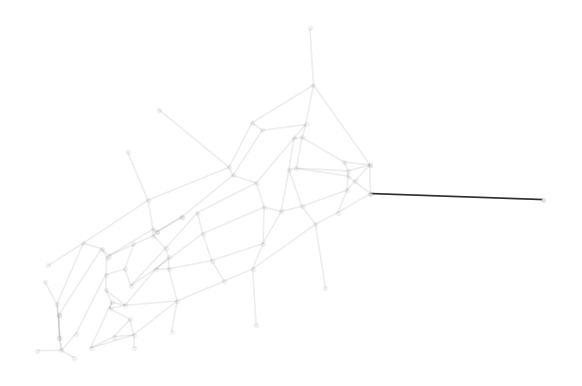

In [348]:
from IPython.display import Image
Image('fig/cpp_route_animation.gif')